# Data Analysis Notebook

This notebook performs comprehensive exploratory data analysis (EDA) on the COMP432 competition dataset.

## Analysis Steps

1. **Label Distribution Analysis**: Understand class balance/imbalance
2. **Feature Distribution & Statistics**: Analyze feature characteristics
3. **Feature Correlation & Redundancy**: Identify correlated features
4. **Dimensionality Analysis**: Explore data dimensionality using PCA



In [1]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import our data loader
from data_loader import load_train_data, load_test_data

# Set up plotting style
# Try different style names for compatibility with different matplotlib versions
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('ggplot')

sns.set_palette("husl")

# Create figures directory if it doesn't exist
figures_dir = os.path.join('..', 'reports', 'figures')
os.makedirs(figures_dir, exist_ok=True)

print("[OK] Libraries imported successfully")
print(f"[INFO] Figures will be saved to: {figures_dir}")



[OK] Libraries imported successfully
[INFO] Figures will be saved to: ../reports/figures


In [2]:
# Load the training data
X, y = load_train_data()

print(f"[OK] Data loaded successfully")
print(f"[INFO] Features shape: {X.shape}")
print(f"[INFO] Labels shape: {y.shape}")
print(f"[INFO] Number of classes: {len(np.unique(y))}")
print(f"[INFO] Class labels range: {y.min()} to {y.max()}")



[OK] Data loaded successfully
[INFO] Features shape: (115406, 500)
[INFO] Labels shape: (115406,)
[INFO] Number of classes: 50
[INFO] Class labels range: 0 to 49


## Step 1: Label Distribution Analysis

We analyze the distribution of class labels to understand if the dataset is balanced or imbalanced.


In [3]:
# Count samples per class
unique_labels, counts = np.unique(y, return_counts=True)
class_counts = pd.Series(counts, index=unique_labels).sort_index()

# Calculate statistics
min_samples = class_counts.min()
max_samples = class_counts.max()
mean_samples = class_counts.mean()
std_samples = class_counts.std()

print(f"[INFO] Minimum samples per class: {min_samples}")
print(f"[INFO] Maximum samples per class: {max_samples}")
print(f"[INFO] Mean samples per class: {mean_samples:.2f}")
print(f"[INFO] Standard deviation: {std_samples:.2f}")

# Check if classes are balanced
# We consider classes balanced if std/mean < 0.2 (20% variation)
coefficient_of_variation = std_samples / mean_samples
if coefficient_of_variation < 0.2:
    balance_status = "balanced"
else:
    balance_status = "imbalanced"

print(f"[INFO] Coefficient of variation: {coefficient_of_variation:.4f}")
print(f"[INFO] Dataset is: {balance_status}")



[INFO] Minimum samples per class: 2303
[INFO] Maximum samples per class: 2310
[INFO] Mean samples per class: 2308.12
[INFO] Standard deviation: 1.85
[INFO] Coefficient of variation: 0.0008
[INFO] Dataset is: balanced


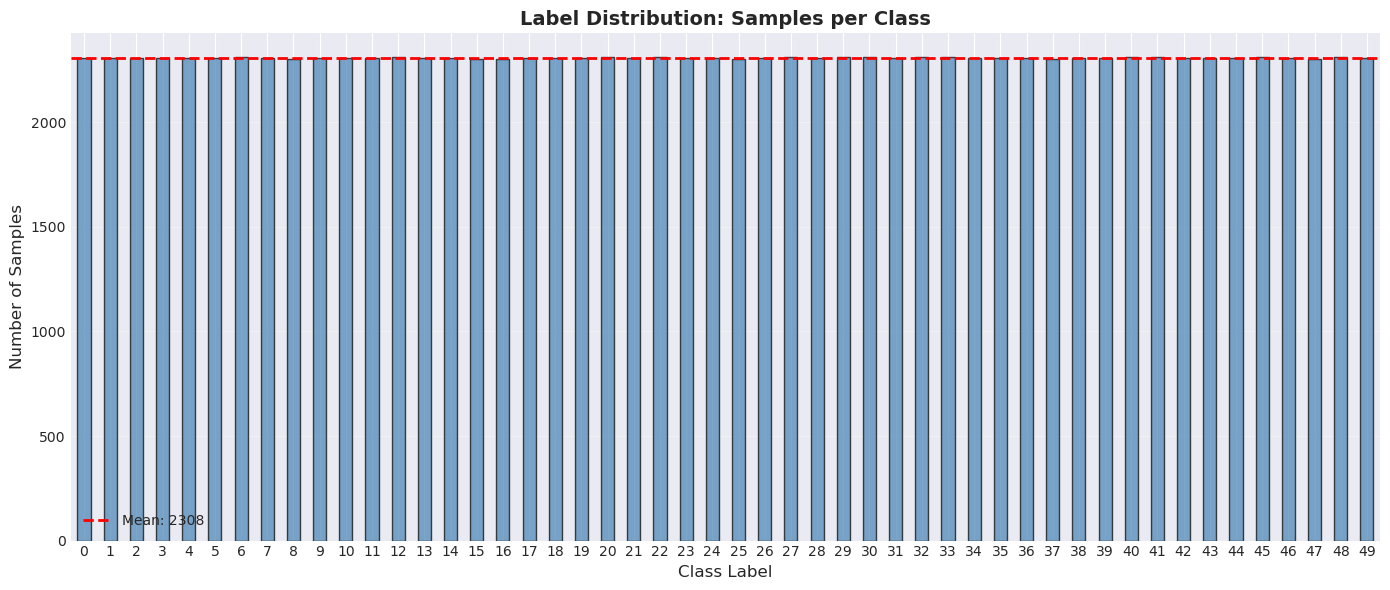

[OK] Label distribution plot saved


In [4]:
# Create bar plot of class frequencies
plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar', color='steelblue', edgecolor='black', alpha=0.7)
plt.title('Label Distribution: Samples per Class', fontsize=14, fontweight='bold')
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Add mean line
plt.axhline(y=mean_samples, color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {mean_samples:.0f}')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'label_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Label distribution plot saved")



## Step 2: Feature Distribution & Statistics

We analyze the distribution and statistics of features to understand their characteristics, check for normalization, and identify potential issues.


In [5]:
# Compute descriptive statistics for all features
feature_means = np.mean(X, axis=0)
feature_stds = np.std(X, axis=0)
feature_mins = np.min(X, axis=0)
feature_maxs = np.max(X, axis=0)

# Create summary statistics DataFrame
feature_stats = pd.DataFrame({
    'mean': feature_means,
    'std': feature_stds,
    'min': feature_mins,
    'max': feature_maxs
})

print("[INFO] Feature Statistics Summary:")
print(feature_stats.describe())

# Check if features are normalized
# Features are considered normalized if mean is close to 0 and std is close to 1
mean_of_means = np.mean(feature_means)
mean_of_stds = np.mean(feature_stds)

print(f"\n[INFO] Mean of feature means: {mean_of_means:.6f}")
print(f"[INFO] Mean of feature stds: {mean_of_stds:.6f}")

if abs(mean_of_means) < 0.1 and abs(mean_of_stds - 1.0) < 0.2:
    print("[INFO] Features appear to be normalized (mean ~0, std ~1)")
else:
    print("[INFO] Features do not appear to be normalized")



[INFO] Feature Statistics Summary:
             mean         std    min         max
count  500.000000  500.000000  500.0  500.000000
mean     0.015211    0.040407    0.0    0.514588
std      0.005748    0.010154    0.0    0.116221
min      0.000936    0.007772    0.0    0.226455
25%      0.011735    0.034507    0.0    0.428820
50%      0.014387    0.039167    0.0    0.500000
75%      0.017360    0.044827    0.0    0.577350
max      0.050261    0.099038    0.0    0.962520

[INFO] Mean of feature means: 0.015211
[INFO] Mean of feature stds: 0.040407
[INFO] Features do not appear to be normalized


In [6]:
# Analyze sparsity: count zeros per feature
zero_counts = np.sum(X == 0, axis=0)
sparsity_per_feature = zero_counts / X.shape[0] * 100  # Percentage of zeros

print(f"[INFO] Sparsity analysis:")
print(f"[INFO] Mean sparsity per feature: {np.mean(sparsity_per_feature):.2f}%")
print(f"[INFO] Max sparsity: {np.max(sparsity_per_feature):.2f}%")
print(f"[INFO] Min sparsity: {np.min(sparsity_per_feature):.2f}%")
print(f"[INFO] Features with >90% zeros: {np.sum(sparsity_per_feature > 90)}")
print(f"[INFO] Features with >50% zeros: {np.sum(sparsity_per_feature > 50)}")



[INFO] Sparsity analysis:
[INFO] Mean sparsity per feature: 85.12%
[INFO] Max sparsity: 98.49%
[INFO] Min sparsity: 67.13%
[INFO] Features with >90% zeros: 42
[INFO] Features with >50% zeros: 500


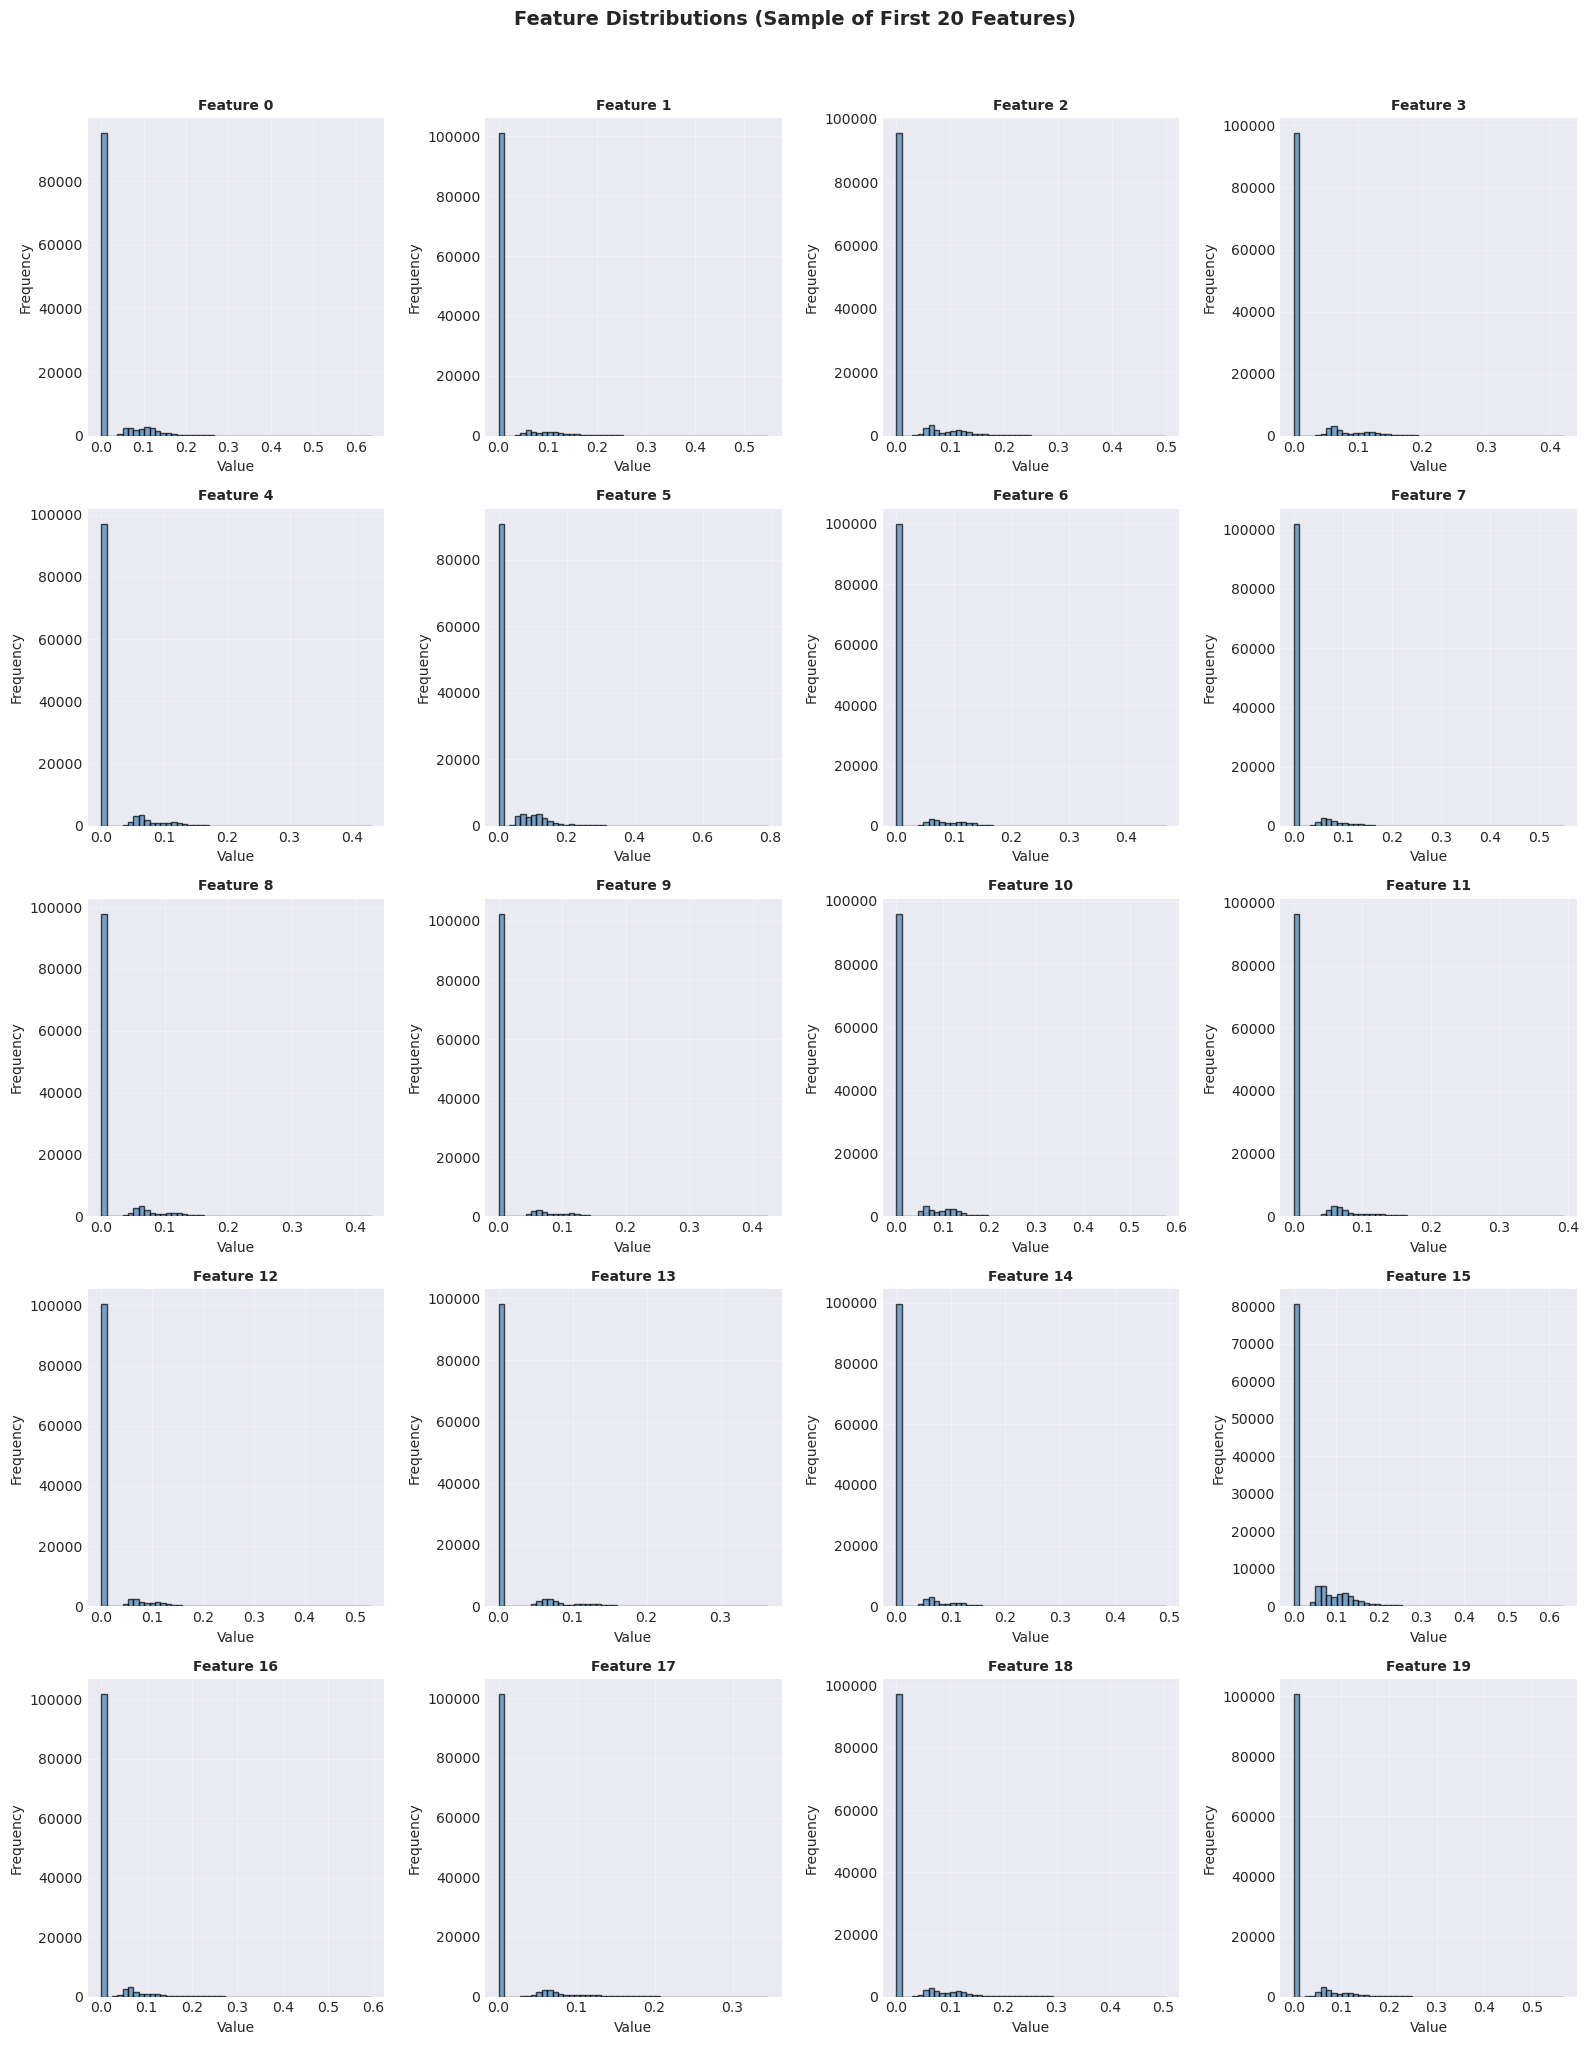

[OK] Feature distribution plots saved


In [7]:
# Create histograms for a sample of features (first 20 features)
n_features_to_plot = min(20, X.shape[1])
n_cols = 4
n_rows = (n_features_to_plot + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i in range(n_features_to_plot):
    axes[i].hist(X[:, i], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Feature {i}', fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.3)

# Hide unused subplots
for i in range(n_features_to_plot, len(axes)):
    axes[i].axis('off')

plt.suptitle('Feature Distributions (Sample of First 20 Features)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'feature_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Feature distribution plots saved")



/tmp/ipykernel_10652/2516840578.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sample_features, labels=[f'F{i}' for i in range(n_features_to_plot)])


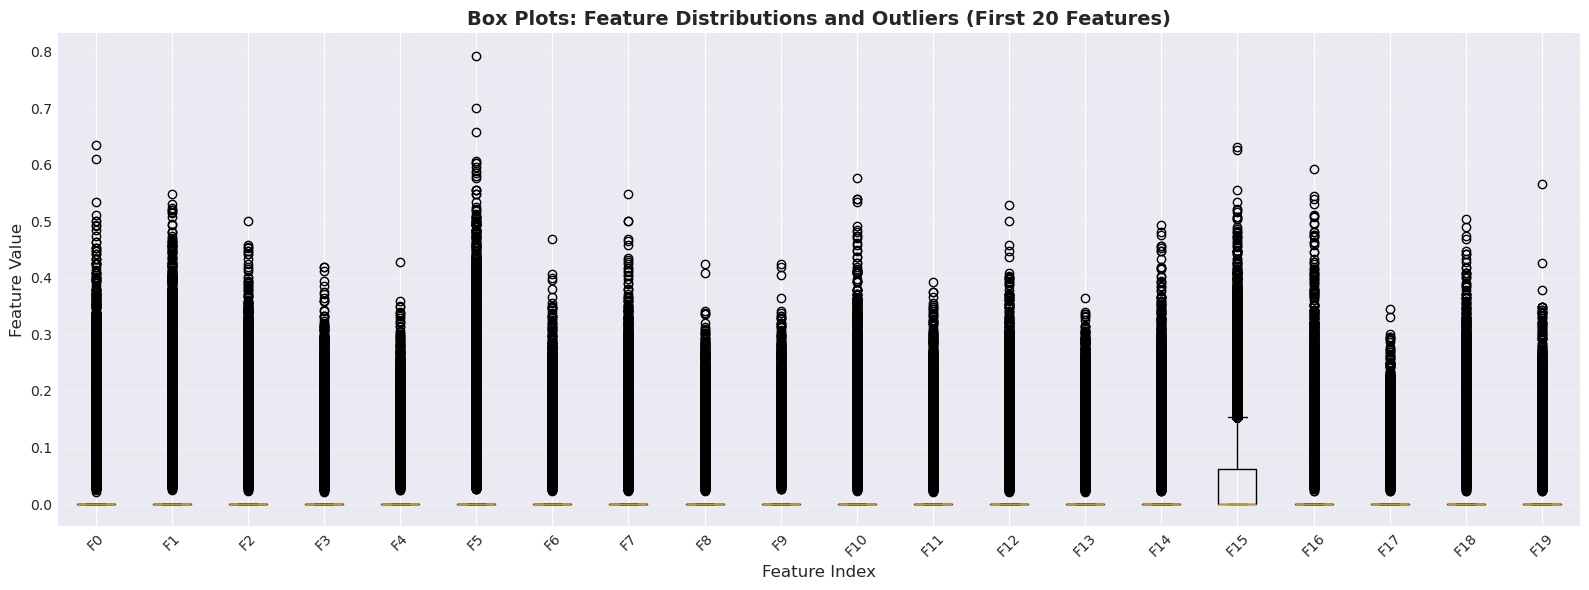

[OK] Feature box plots saved


In [8]:
# Create box plots for a sample of features to detect outliers
n_features_to_plot = min(20, X.shape[1])
sample_features = X[:, :n_features_to_plot]

plt.figure(figsize=(16, 6))
plt.boxplot(sample_features, labels=[f'F{i}' for i in range(n_features_to_plot)])
plt.title('Box Plots: Feature Distributions and Outliers (First 20 Features)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Feature Index', fontsize=12)
plt.ylabel('Feature Value', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'feature_boxplots.png'), dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Feature box plots saved")



## Step 3: Feature Correlation & Redundancy

We analyze correlations between features to identify redundant features. Due to memory constraints, we'll analyze a random sample of features.


In [9]:
# Sample a subset of features for correlation analysis
# We'll use 100 features to keep memory usage reasonable
n_features_to_analyze = min(100, X.shape[1])
feature_indices = np.random.choice(X.shape[1], size=n_features_to_analyze, replace=False)
feature_indices = np.sort(feature_indices)  # Sort for better visualization

X_sample = X[:, feature_indices]

print(f"[INFO] Analyzing correlations for {n_features_to_analyze} randomly sampled features")
print(f"[INFO] Feature indices: {feature_indices[:10]} ... {feature_indices[-10:]}")

# Compute correlation matrix
correlation_matrix = np.corrcoef(X_sample.T)

print(f"[OK] Correlation matrix computed: shape {correlation_matrix.shape}")



[INFO] Analyzing correlations for 100 randomly sampled features
[INFO] Feature indices: [ 1 14 15 19 21 25 27 29 37 41] ... [444 449 456 462 468 470 473 490 492 494]
[OK] Correlation matrix computed: shape (100, 100)


In [10]:
# Identify highly correlated feature pairs
# We'll look for correlations > 0.9 (excluding diagonal)
high_corr_threshold = 0.9
high_corr_pairs = []

for i in range(len(feature_indices)):
    for j in range(i + 1, len(feature_indices)):
        corr_value = correlation_matrix[i, j]
        if abs(corr_value) > high_corr_threshold:
            high_corr_pairs.append((feature_indices[i], feature_indices[j], corr_value))

print(f"[INFO] Found {len(high_corr_pairs)} feature pairs with correlation > {high_corr_threshold}")

if len(high_corr_pairs) > 0:
    print("[INFO] Top highly correlated pairs:")
    # Sort by absolute correlation
    high_corr_pairs_sorted = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)
    for i, (feat1, feat2, corr) in enumerate(high_corr_pairs_sorted[:10]):
        print(f"  Features {feat1} and {feat2}: correlation = {corr:.4f}")
else:
    print("[INFO] No highly correlated feature pairs found in the sample")



[INFO] Found 0 feature pairs with correlation > 0.9
[INFO] No highly correlated feature pairs found in the sample


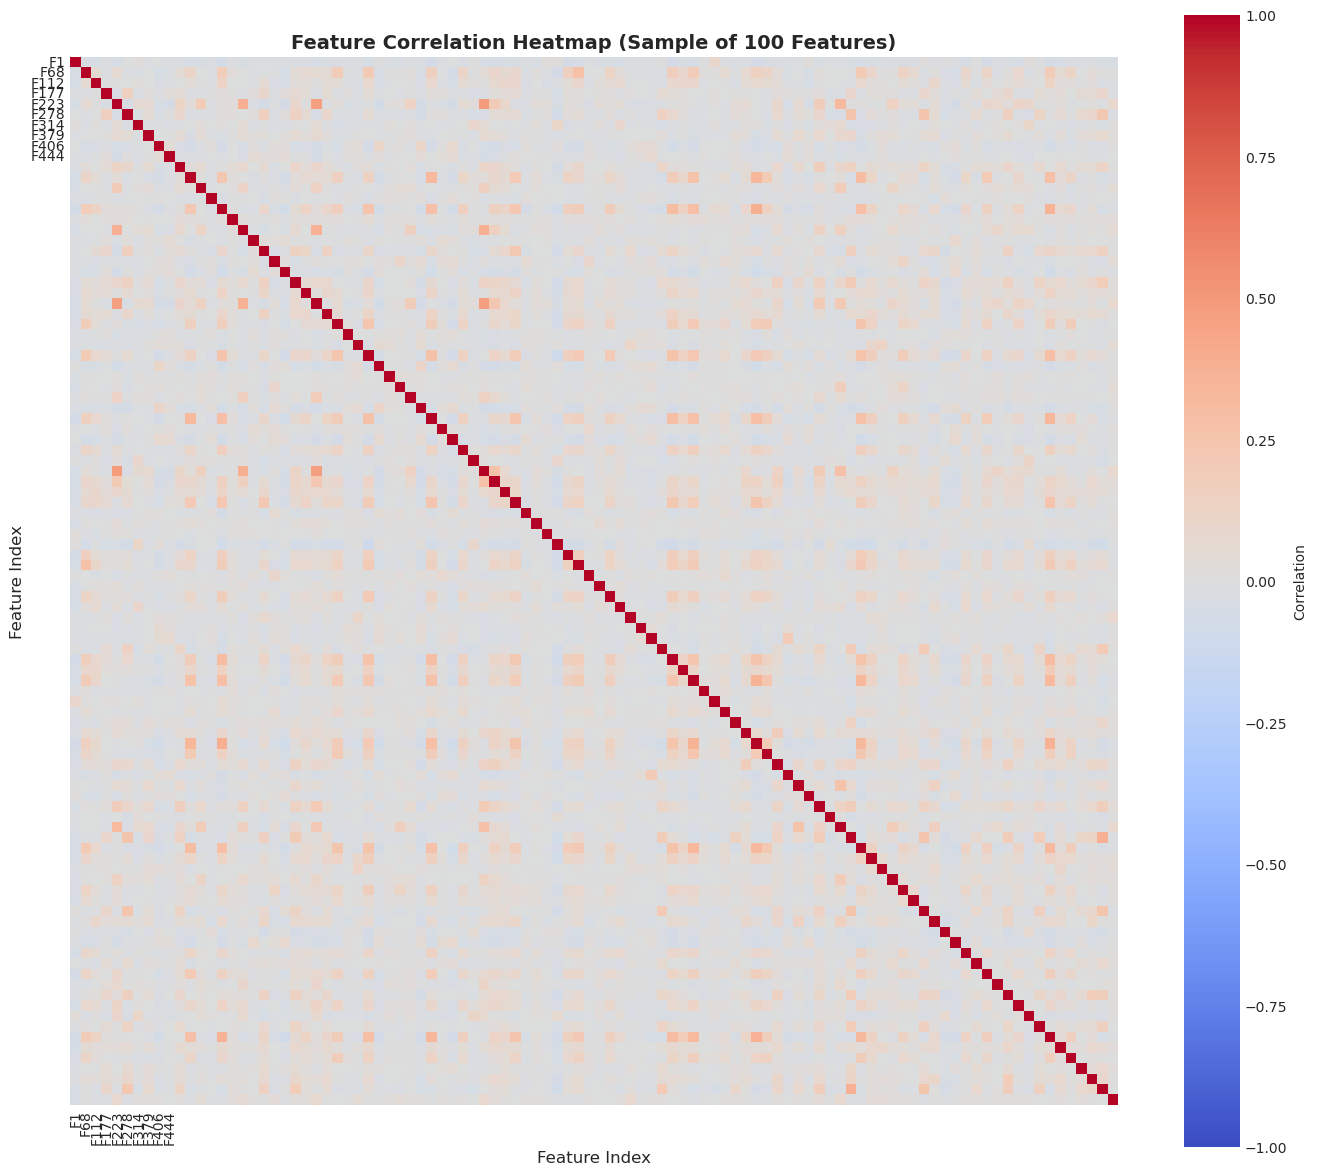

[OK] Correlation heatmap saved


In [11]:
# Create correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, 
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            cbar_kws={'label': 'Correlation'},
            xticklabels=[f'F{i}' for i in feature_indices[::10]],  # Show every 10th label
            yticklabels=[f'F{i}' for i in feature_indices[::10]],
            fmt='.2f')

plt.title(f'Feature Correlation Heatmap (Sample of {n_features_to_analyze} Features)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Feature Index', fontsize=12)
plt.ylabel('Feature Index', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Correlation heatmap saved")



## Step 4: Dimensionality Analysis

We perform Principal Component Analysis (PCA) to understand the effective dimensionality of the data and how much variance is captured by different numbers of components.


In [12]:
# Standardize features before PCA (PCA is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("[OK] Features standardized for PCA")

# Perform PCA
pca = PCA()
pca.fit(X_scaled)

# Get explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"[OK] PCA completed")
print(f"[INFO] Total number of components: {len(explained_variance_ratio)}")



[OK] Features standardized for PCA
[OK] PCA completed
[INFO] Total number of components: 500


In [13]:
# Find how many components are needed for different variance thresholds
variance_thresholds = [0.90, 0.95, 0.99]
n_components_needed = {}

for threshold in variance_thresholds:
    n_comp = np.argmax(cumulative_variance >= threshold) + 1
    n_components_needed[threshold] = n_comp
    actual_variance = cumulative_variance[n_comp - 1]
    print(f"[INFO] {threshold*100:.0f}% variance: {n_comp} components (actual: {actual_variance*100:.2f}%)")

print(f"\n[INFO] First component explains {explained_variance_ratio[0]*100:.2f}% of variance")
print(f"[INFO] First 10 components explain {cumulative_variance[9]*100:.2f}% of variance")
print(f"[INFO] First 50 components explain {cumulative_variance[49]*100:.2f}% of variance")



[INFO] 90% variance: 412 components (actual: 90.05%)
[INFO] 95% variance: 451 components (actual: 95.04%)
[INFO] 99% variance: 488 components (actual: 99.02%)

[INFO] First component explains 3.84% of variance
[INFO] First 10 components explain 13.00% of variance
[INFO] First 50 components explain 25.53% of variance


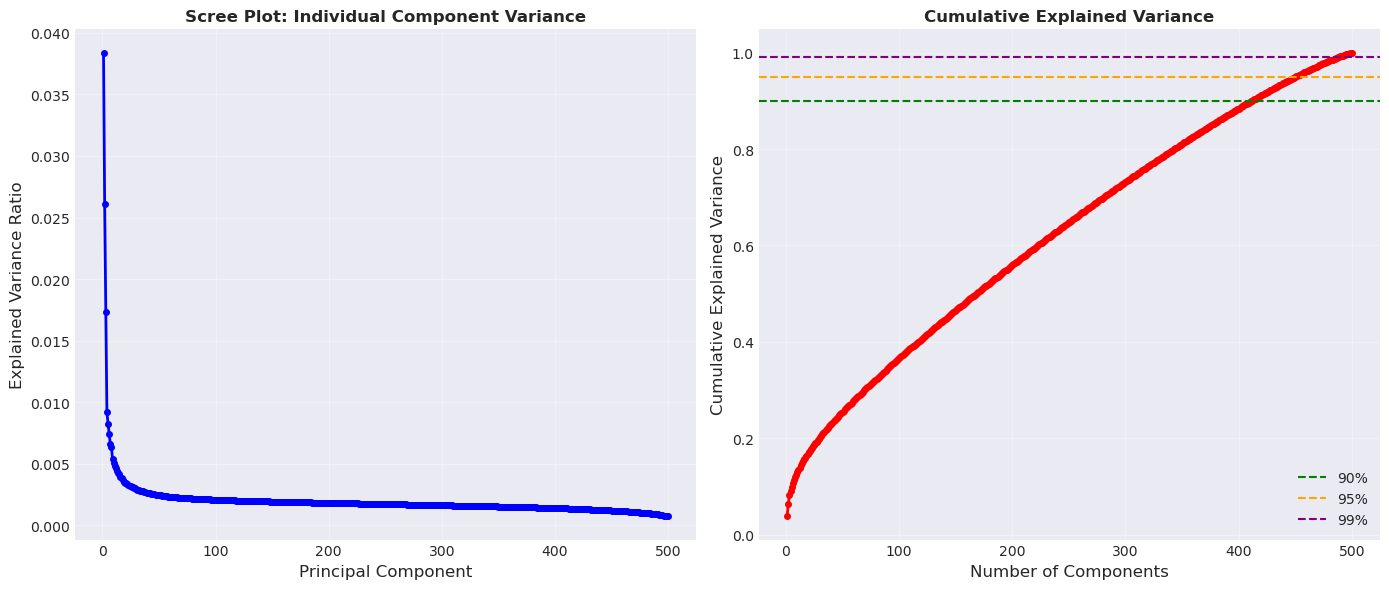

[OK] Scree plot saved


In [17]:
# Create scree plot (eigenvalues vs component number)
# We'll show the first 100 components for clarity
n_components_to_plot = min(1000, len(explained_variance_ratio))

plt.figure(figsize=(14, 6))

# Plot individual explained variance
plt.subplot(1, 2, 1)
plt.plot(range(1, n_components_to_plot + 1), 
         explained_variance_ratio[:n_components_to_plot], 
         'b-o', markersize=4, linewidth=2)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('Scree Plot: Individual Component Variance', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

# Plot cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, n_components_to_plot + 1), 
         cumulative_variance[:n_components_to_plot], 
         'r-o', markersize=4, linewidth=2)
plt.axhline(y=0.90, color='green', linestyle='--', label='90%')
plt.axhline(y=0.95, color='orange', linestyle='--', label='95%')
plt.axhline(y=0.99, color='purple', linestyle='--', label='99%')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'pca_scree_plot.png'), dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Scree plot saved")



In [15]:
# Project data onto first 2 principal components for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"[OK] Data projected onto 2D PCA space")
print(f"[INFO] Variance explained by PC1: {pca_2d.explained_variance_ratio_[0]*100:.2f}%")
print(f"[INFO] Variance explained by PC2: {pca_2d.explained_variance_ratio_[1]*100:.2f}%")
print(f"[INFO] Total variance explained by 2D projection: {sum(pca_2d.explained_variance_ratio_)*100:.2f}%")



[OK] Data projected onto 2D PCA space
[INFO] Variance explained by PC1: 3.84%
[INFO] Variance explained by PC2: 2.61%
[INFO] Total variance explained by 2D projection: 6.45%


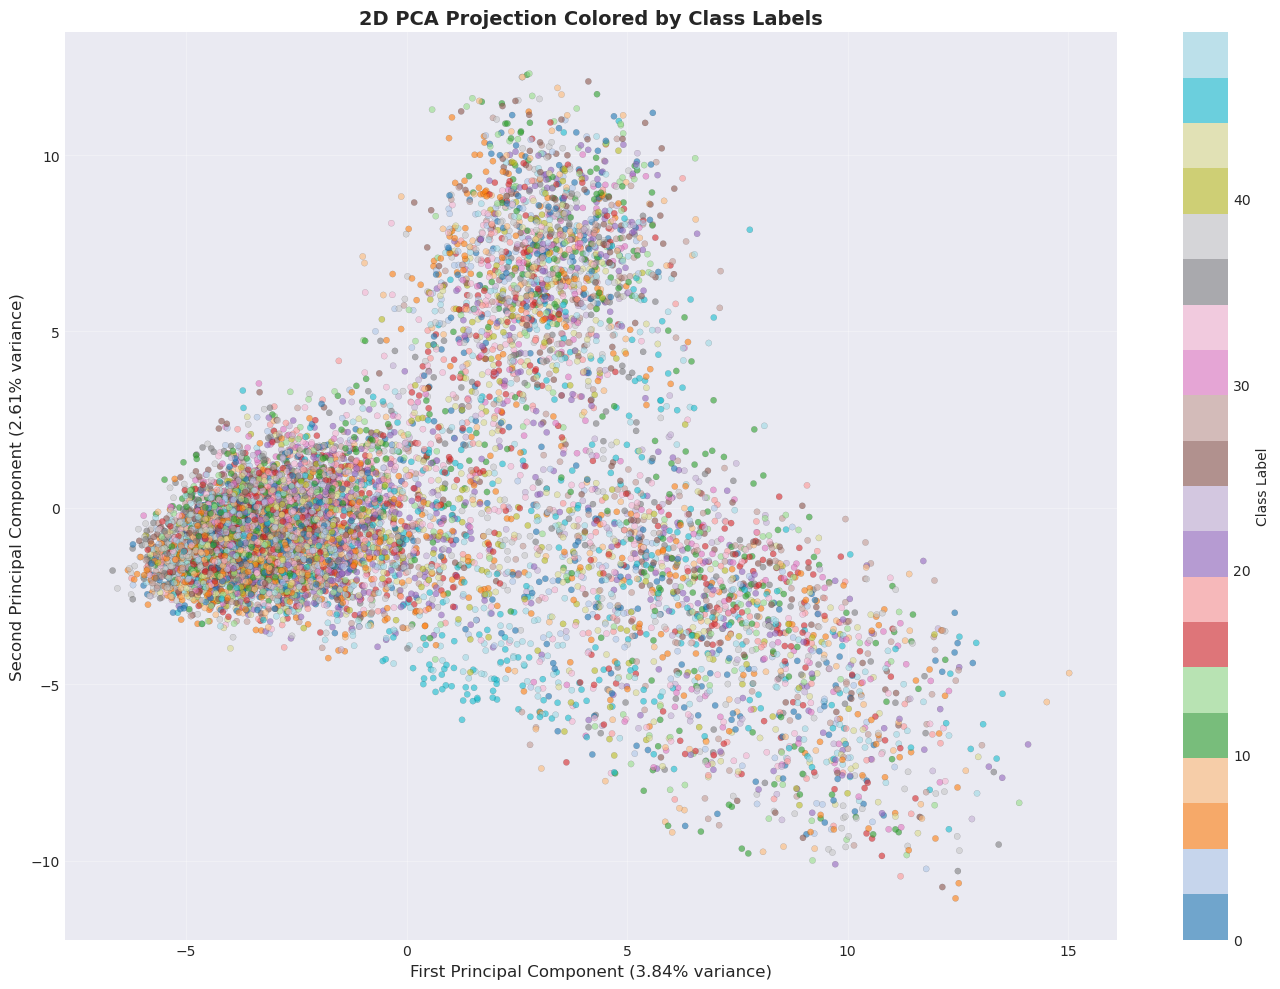

[OK] 2D PCA projection saved (showing 10000 samples)


In [16]:
# Create 2D PCA projection colored by class labels
# Sample data for visualization (too many points to plot all)
n_samples_to_plot = min(10000, X_pca_2d.shape[0])
sample_indices = np.random.choice(X_pca_2d.shape[0], size=n_samples_to_plot, replace=False)
X_plot = X_pca_2d[sample_indices]
y_plot = y[sample_indices]

plt.figure(figsize=(14, 10))
scatter = plt.scatter(X_plot[:, 0], X_plot[:, 1], 
                     c=y_plot, 
                     cmap='tab20',
                     alpha=0.6,
                     s=20,
                     edgecolors='black',
                     linewidths=0.1)

plt.colorbar(scatter, label='Class Label')
plt.xlabel(f'First Principal Component ({pca_2d.explained_variance_ratio_[0]*100:.2f}% variance)', 
           fontsize=12)
plt.ylabel(f'Second Principal Component ({pca_2d.explained_variance_ratio_[1]*100:.2f}% variance)', 
           fontsize=12)
plt.title('2D PCA Projection Colored by Class Labels', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'pca_2d_projection.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"[OK] 2D PCA projection saved (showing {n_samples_to_plot} samples)")



# Checking performance on scikit learn models

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_loader import load_train_data

X, y = load_train_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=23)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Logistic Regression

In [ ]:


clf = LogisticRegression(max_iter=500, n_jobs=-1)
clf.fit(X_train, y_train)
print(f"Validation accuracy: {clf.score(X_val, y_val)}")


Validation accuracy: 0.3714978915140662


## Random Forest

In [2]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)
print(f"Validation accuracy: {clf.score(X_val, y_val)}")



Validation accuracy: 0.4554618450696089


## Summary

This analysis has provided insights into:

1. **Label Distribution**: Whether classes are balanced or imbalanced
2. **Feature Statistics**: Feature distributions, normalization status, and sparsity
3. **Feature Correlations**: Identification of redundant features
4. **Dimensionality**: Effective dimensionality of the data through PCA

These insights will guide model selection and hyperparameter tuning decisions.

